# Chapter 7: Ensemble learning and random forests

In *Ensemble learning*, a group of predictors are used. Their predictions are aggregated, often resulting in a better prediction that when a single predictor is used.

*Random forests* are a group of Decision Tree classifiers, each trained on a different subset of the training data. The prediction is then the class that gets predicted by the most of the individual Decision Trees.

## Voting classifiers

Suppose we have several classifiers, each trained and achieving 80% accuracy. For example maybe we have a Logistic Regression, a Random Forest, an SVM and a K-nearest neighbor classifiers. If we aggregate the predictions of each, we can predict the class that is getting the most votes. This majority-vote classifier is called a *hard voting* classifier.

This voting classifier often achieves a higher accuracy than the best performing classifier from the ensemble. In fact, the aggregate can reach quite high accuracies (high learner) even if each individual classifier does only slightly better than random guessing (weak learner). This works best when the predictors are as independent from each other as possible. This could mean using very different algorithms, increasing the chance that the errors being made by each classifiers are different.

Here we create and train a voting classifier in Scikit-Learn, composed of three diverse classifiers.

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [76]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')



In [77]:
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)



In [78]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [79]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.896
VotingClassifier 0.904


*Soft voting* is when you take advantage of the predict_proba() method (assuming all the classifiers in your ensemble have it) to predict the class with the heighest class probability, averaged over all the classifiers. 

## Bagging and pasting

Another approach to obtaining a diverse set of classifiers is to use the same training algorithm for each predictor, but to train in on different random subsets of the training set. When sampling the training set with replacement, this is called *bagging* (bootstrap aggregating) and when sampling is done without replacement, it is called *pasting*.


In [80]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [81]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1) #bootstrap=False for pasting
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [28]:
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
plot_step=0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bag_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


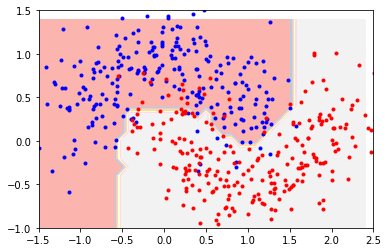

In [30]:
plt.plot(X[y==0,0],X[y==0,1], 'b.')
plt.plot(X[y==1,0],X[y==1,1], 'r.')
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

plt.ylim(-1,1.5);
plt.xlim(-1.5,2.5);

### Out of bag evaluation

With bagging, some instances might be sampled several times by the same predictor, while some might not get sampled at all. The instances that are not sampled are called *out of bag* (oob) instances. The oob differ between predictors. Since the oob are never seen by the predictor, they can be used for evaluation.

In [32]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True)

In [33]:
bag_clf.oob_score_

0.896

In [34]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## Random patches and random subspaces

The BaggingClassifier class also allows for feature sampling, in addition to instance sampling. This means that each individual predictor can be trained an a random subset of the input features. This is useful when dealing with a dataset with high-dimensional inputs (such as images). Sampling both instances and features is called the *Random patches* method. Keeping all instances and sampling features is called the *Random subspaces* method. Sampling features results in trading a bit more bias for a lower variance, due to more predictor diversity.

## Random forests

A Random Forest is an ensemble of Decision Trees, usually trained by the bagging method, typically with max_samples set to the size of the training set. Random Forests can be implemented using the RandomForestClassifier class (similarly RandomForestRegressor for regression tasks).

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [48]:
y_pred_rf = rnd_clf.predict(X_test)

For the most part, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier in addition to those of a BaggingClassifier. The Random Forest algorithm adds randomness when training trees. At each node, it searches for the best feature from a random subset of the features, isntead of searching from all the features. This once again adds to the diversity of the predictors (trees) and trades higher bias for lower variance. When aggregated though, this typically leads to a better model.

The following BaggingClassifier is roughly equivalent to the above RandomForestClassifier:

In [49]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1, bootstrap=True, n_jobs=-1)

### Extra-trees

When growing a Random Forest, only a random subset of the features is considered at each node. Even more randomness can be introduced by also using random thresholds for each feature, rather than optimizing for the best threshold. This is called *Extremely Randomized Trees*, or Extra-Trees. This again introduces a higher bias/lower variance, and is faster to train than regular Random Forests.

### Feature importance

Random Forests can measure the relative importance of each feature. 

In [50]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])


RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [51]:
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.08337175575236569
sepal width (cm) 0.025739789694771174
petal length (cm) 0.43123151566571843
petal width (cm) 0.4596569388871447


### Random forest classifier on the MNIST dataset

Here we train a Random Forest classifier on the MNIST dataset of handwritten digits and find the importance of each pixel.

In [44]:
from sklearn.datasets import fetch_openml

In [72]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]


In [73]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X, y)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

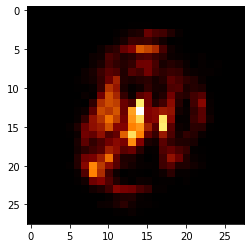

In [74]:
plt.imshow(np.reshape(rnd_clf.feature_importances_, (28,28)), cmap='afmhot')

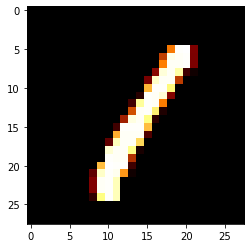

In [70]:
plt.imshow(np.reshape(mnist["data"][3], (28,28)), cmap='afmhot')

## Boosting

Boosting is any Ensemble methog that combines several weak learners into a strong learner. Usually, boosting is a way of training predictors sequentially, each one improving on the previous.

### AdaBoost

The most popular boosting method is Adaptive Boosting (AdaBoost). A predictor corrects its predecessor by focusing on the training instances that were previously overfit.


In [84]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split


In [85]:

X,y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)



In [98]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [99]:
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
plot_step=0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = ada_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

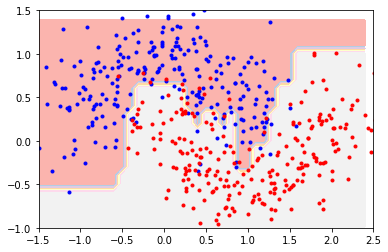

In [100]:
plt.plot(X[y==0,0],X[y==0,1], 'b.')
plt.plot(X[y==1,0],X[y==1,1], 'r.')
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

plt.ylim(-1,1.5);
plt.xlim(-1.5,2.5);

### Gradient boosting

Another boosting algorithm is Gradient Boosting. It is similar to AdaBoosting, except instead of tweaking weights at every iteration, it tries to fit the new predictor to the residual errors.

In [101]:
from sklearn.tree import DecisionTreeRegressor

In [157]:
m=100
X = np.linspace(-1,1,m) + np.random.uniform(-.1, .1, m)
X_new = np.linspace(-1,1,m)
y = X**2 + np.random.uniform(-.1, .1, m)

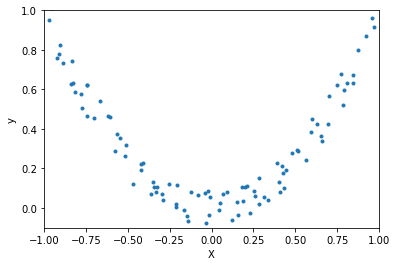

In [158]:
plt.plot(X, y,'.')
plt.xlabel("X")
plt.ylabel("y")
plt.xlim(-1,1)
plt.ylim(-0.1,1)
plt.show()


In [159]:
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X.reshape(-1, 1),y.reshape(-1, 1))

DecisionTreeRegressor(max_depth=2)

In [160]:
y2 = y - tree_reg1.predict(X.reshape(-1, 1))
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X.reshape(-1, 1),y2.reshape(-1, 1))

DecisionTreeRegressor(max_depth=2)

In [161]:
y3 = y2 - tree_reg2.predict(X.reshape(-1, 1))
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X.reshape(-1, 1),y3.reshape(-1, 1))

DecisionTreeRegressor(max_depth=2)

In [162]:
y_pred = sum(tree.predict(X_new.reshape(-1, 1)) for tree in (tree_reg1, tree_reg2, tree_reg3))

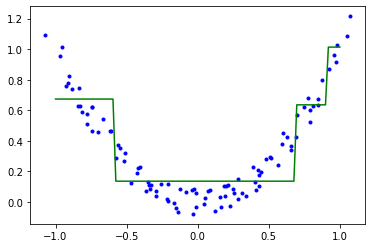

In [166]:
plt.plot(X,y, 'b.')
plt.plot(X_new, tree_reg1.predict(X_new.reshape(-1, 1)), 'g-')
plt.show()

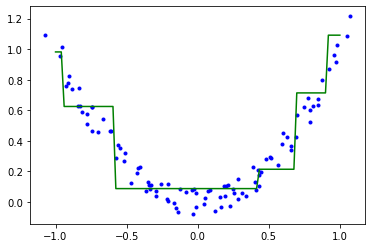

In [170]:
plt.plot(X,y, 'b.')
plt.plot(X_new, tree_reg1.predict(X_new.reshape(-1, 1))+
         tree_reg2.predict(X_new.reshape(-1, 1)),
         'g-')
plt.show()

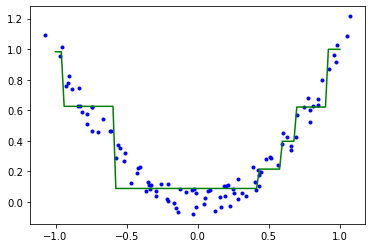

In [163]:
plt.plot(X,y, 'b.')
plt.plot(X_new, y_pred, 'g-')
plt.show()

In [182]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1)
gbrt.fit(X.reshape(-1,1),y.reshape(-1,1))
gbrt2 = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1)
gbrt2.fit(X.reshape(-1,1),y.reshape(-1,1))

/Users/home/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/home/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingRegressor(max_depth=2, n_estimators=200)

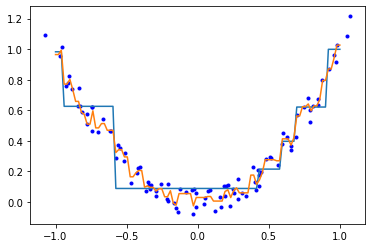

In [183]:
plt.plot(X, y, 'b.')
plt.plot(X_new, gbrt.predict(X_new.reshape(-1,1)))
plt.plot(X_new, gbrt2.predict(X_new.reshape(-1,1)))
plt.show()

The optimal number of trees can be found by using early stopping (which was covered in Chapter 4).

In [184]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [190]:
X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train.reshape(-1,1), y_train)

errors = [mean_squared_error(y_val, y_pred)
        for y_pred in gbrt.staged_predict(X_val.reshape(-1,1))]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train.reshape(-1,1), y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=87)